In [14]:
import matplotlib.pylab as plt
import torch
%matplotlib inline
import torchvision.transforms.functional as TF
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as tv_F
from PIL import Image,ImageDraw
import numpy as np

In [4]:
def rescale_label(a,b):
    div = [ai*bi for ai,bi in zip(a,b)]
    return div

In [5]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [6]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=2,padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3,stride=1,padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3,padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3,padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3,padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)


In [7]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x=F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = self.fc1(x)
    return x

In [8]:
Net.__init__=__init__
Net.forward=forward

In [9]:
params_model={
        "input_shape": (3,256,256),
        "initial_filters": 16, 
        "num_outputs": 2,
            }
# create model
model = Net(params_model)
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(19, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(51, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(115, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(243, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=2, bias=True)
)

In [10]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    model=model.to(device)  

In [11]:
path2weights="./models/weights_smoothl1.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [36]:
def show_single_box(img,label,w_h=(50,50)): 
    label=rescale_label(label,img.shape[1:])
    img=tv_F.to_pil_image(img) 

    w,h=w_h 
    cx,cy=label
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="yellow",width=2)

    plt.imshow(np.asarray(img))

In [81]:
def predict_fovea_location(img_path):
    from PIL import Image
    img = Image.open(img_path) #PIL Image
    img_resized = img.resize((256,256))
    img_tensor = TF.to_tensor(img_resized)
    with torch.no_grad():
        label_pred=model(img_tensor.unsqueeze(0).to(device))[0].cpu()
        #print(label_pred)
    plt.figure(figsize=(5,4),facecolor='lightgrey')
    plt.title('Fovea Detector-'+img_path)
    plt.axis('off')
    show_single_box(img_tensor,label_pred)

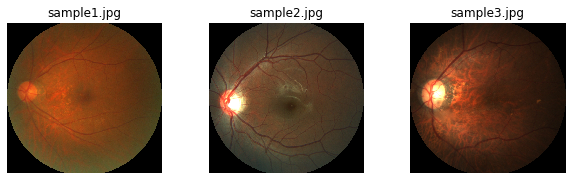

In [79]:
image_names=['sample1.jpg','sample2.jpg','sample3.jpg']
plt.figure(facecolor='white')
plt.rcParams['figure.figsize'] = (10, 5)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i,name in enumerate(image_names):
    plt.subplot(1, 3, i+1)
    img = Image.open(name)
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.title(name)
    plt.grid(False)

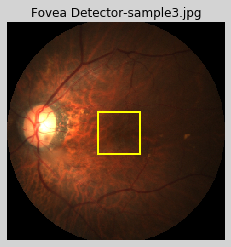

In [88]:
predict_fovea_location('sample3.jpg')